In [9]:
import os
import json
import jsonlines
import pandas as pd
data_path="../data/analysis_data_quantity"
fl=os.listdir(data_path)
data=[]

runname_mapping={
    "rl.grpo_llama.3b_analysis_mm.web.pro.plus.20B_math.8k_0411_2209": "20B Tokens",
    "rl.grpo_llama.3b_analysis_mm.web.pro.plus.70B_math.8k_0411_1425": "70B Tokens",
    "rl.grpo_llama.3b_analysis_mm.web.pro.plus.100B_math.8k_0411_1425": "100B Tokens"
}    
color_mapping={
    "20B Tokens": "#6FB9FF",
    "70B Tokens": "#C411CF",
    "100B Tokens": "#1b2b65",
}
benchmark_mapping={
    "amc23": "AMC23",
    "gsm8k": "GSM8k",
    "math500": "MATH500",
    "olympiadbench": "Olympiad Bench"
}


In [4]:
import os
import re
import pandas as pd

def process_csv_directory(directory_path):
    # 初始化三层字典结构
    result_dict = {}
    
    # 遍历目录中的所有文件
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            # 解析文件名中的metric和benchmark
            match = re.match(r"^(.+?)_(.+?)\.csv$", filename)
            if not match:
                continue
            metric, benchmark = match.groups()
            
            # 读取CSV文件
            filepath = os.path.join(directory_path, filename)
            df = pd.read_csv(filepath)
            
            # 筛选列：排除包含MIN/MAX/step的列（不区分大小写）
            valid_columns = [
                col for col in df.columns 
                if not any(kwd in col.upper() for kwd in ["MIN", "MAX", "STEP"])
            ]
            filtered_df = df[valid_columns]
            
            # 构建字典结构
            metric_dict = result_dict.setdefault(metric, {})
            benchmark_dict = metric_dict.setdefault(benchmark, {})
            
            # 将每列数据转换为list存储
            for col in filtered_df.columns:
                legend_name=runname_mapping[col.split(" - ")[0]]
                benchmark_dict[legend_name] = filtered_df[col].tolist()
    
    return result_dict

# 使用方法
final_dict = process_csv_directory(data_path)

/var/folders/ss/_kxc_zqj40nd0k2nxkqcknxh0000gn/T/ipykernel_22204/141712978.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


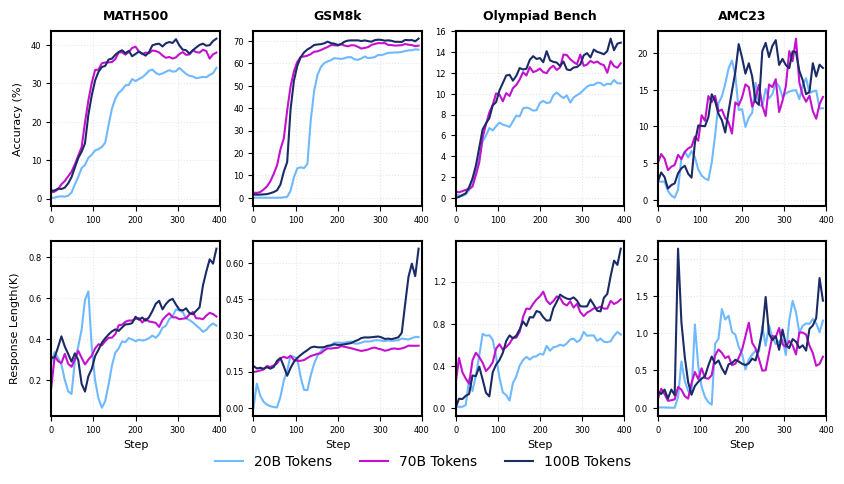

In [8]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from matplotlib.ticker import MaxNLocator

def compute_ema(values, alpha=0.2):
    """Compute Exponential Moving Average with smoothing factor alpha."""
    ema = np.zeros_like(values, dtype=float)
    ema[0] = values[0]
    for t in range(1, len(values)):
        ema[t] = alpha * values[t] + (1 - alpha) * ema[t-1]
    return ema

def plot_combined_charts(data_dict, figsize=(10, 5)):
    # 获取基准测试列表（假设所有metric有相同的benchmarks）
    metrics = list(data_dict.keys())
    benchmarks = ['math500', 'gsm8k', 'olympiadbench', 'amc23']
    n_benchmarks = len(benchmarks)

    # 创建画布和网格布局
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, n_benchmarks, figure=fig, hspace=0.2, wspace=0.2)

    # 颜色配置（可自定义）
    line_styles = ['-', '-']

    # 遍历每个metric行
    for row_idx, metric in enumerate(metrics):
        # 遍历每个benchmark列
        for col_idx, benchmark in enumerate(benchmarks):
            ax = fig.add_subplot(gs[row_idx, col_idx])
            # 每个subfigure的边框粗细
            ax.spines['top'].set_linewidth(1.5)
            ax.spines['bottom'].set_linewidth(1.5)
            ax.spines['left'].set_linewidth(1.5)
            ax.spines['right'].set_linewidth(1.5)
            
            # 获取当前数据集
            try:
                columns = data_dict[metric][benchmark]
            except KeyError:
                continue
            
            # 绘制每条折线
            
            # for line_idx, (col_name, values) in enumerate(columns.items()):
            for line_idx, col_name in enumerate(color_mapping):
                values=columns[col_name]
                if metric.lower()=='length': values=[x/1000 for x in values]
                else: values=[x*100 for x in values]
                truncated = values[:50]
                for idx, x in enumerate(truncated):
                    if not (x<16384): truncated[idx]=0
                x = np.arange(len(truncated)) * 8  # X轴乘8

                ax.set_xlim(0, 400)
                ema = compute_ema(truncated, alpha=0.5)
                ax.plot(
                    x,
                    ema,
                    color=color_mapping[col_name],
                    linestyle=line_styles[line_idx % len(line_styles)],
                    linewidth=1.5,
                    # marker='o' if line_idx == 0 else 's',
                    markersize=2,
                    label=col_name
                )
            
            # if metric in fix_data and benchmark in fix_data[metric]:
            #     for model_name, ref_value in fix_data[metric][benchmark].items():
            #         ax.axhline(
            #             y=ref_value,
            #             linewidth=1,
            #             linestyle='--', 
            #             color=color_mapping[runname_mapping[model_name]],
            #         )
            
            # 设置子图标题和标签
            # ax.set_title(f"{metric.upper()} - {benchmark}", fontsize=10, pad=12)
            ax.set_xlabel("Step" if row_idx == 1 else "", fontsize=8)
            ax.set_ylabel(metric.upper(), fontsize=8)
            if metric == 'length':
                ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))
            
            # 显示图例
            # ax.legend(
            #     loc='upper right',
            #     fontsize=6,
            #     framealpha=0.9,
            #     ncol=1,
            #     borderpad=0.5
            # )

            if row_idx == 0:
                ax.set_title(benchmark_mapping[benchmark], fontsize=9, pad=8, weight='semibold')
            
            # Y轴标签设置（仅第一列）
            if col_idx == 0:
                ylabel = 'Accuracy (%)' if metric == 'acc' else 'Response Length(K)'
                ax.set_ylabel(ylabel, fontsize=8, labelpad=6)
            else:
                ax.set_ylabel("")

            # 统一y轴范围
            # all_values = np.concatenate([v for v in columns.values()])
            # ax.set_ylim(np.nanmin(all_values)*0.9, np.nanmax(all_values)*1.1)
            # 优化刻度显示
            ax.tick_params(axis='both', which='major', labelsize=6)
            ax.grid(True, alpha=0.3, linestyle=':')

            if col_idx == n_benchmarks-1 and row_idx == 0:
                ax.legend(
                    loc='upper left',
                    bbox_to_anchor=(-2.7, -1.35),
                    fontsize=10,
                    ncol=len(runname_mapping),
                    frameon=False
                )

    # 添加大标题
    # plt.suptitle("Benchmarks Performance Analysis", y=0.98, fontsize=14, weight='bold')

    # 调整布局
    plt.tight_layout()
    return fig

# 使用示例
fig = plot_combined_charts(final_dict)
# plt.savefig("../figures/analysis_data_quantity.pdf")
plt.savefig("../figures/analysis_data_quantity.png", bbox_inches='tight', pad_inches=0.05, dpi=300)
plt.show()
